# Cryptocurrency Market Predictor - Recurrent Neural Network

Predicting BTCUSD market

In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read data

In [2]:
dataset = pd.read_csv('C:\\Users\\Jason\\Documents\\Python\\Stock Market Prediction\\Crypto\\BTC_Slopes.csv', nrows=1900)
dataset.tail(2)

,order_date_time,id,trade_px,future_px,aqsum,abqsum,bqsum,abqdt,aqsum3,abqdt^2,...,Spread,ratio5,ratio5dt,distRatio5,distRatio10,sign_vol,trade_volume,price_change,before price_change,god_mode
1874,2017-10-05 06:05:34,323726.166667,4150.015,4151.205,38.019088,-134.445354,172.464443,-4.576568,12.615000,4.576168,...,0.01,0.079774,-0.033529,-3.39,-3.39,-0.014140,0.194564,1.19,1,1691.606323
1875,2017-10-05 06:06:33,324015.833333,4151.205,4154.875,38.940430,-135.265627,174.206057,-4.470653,1.627657,6.356013,...,0.01,0.064427,-0.038431,-2.42,-2.42,-0.183296,0.116427,3.67,1,1691.606323


In [3]:
#pd.to_datetime(odt.index).to_frame()
dataset_px = dataset.filter(['order_date_time','trade_px'], axis=1)
dataset_px.head()

,order_date_time,trade_px
0,2017-10-04 02:32:54,4296.6550
1,2017-10-04 02:33:38,4299.0250
2,2017-10-04 02:33:43,4297.9175
3,2017-10-04 02:33:48,4299.0450
4,2017-10-04 02:33:53,4299.5100


#### Normalize

In [4]:

tdt=dataset.iloc[:, 0:2]
tdt.head(2)
dataset = dataset.drop('order_date_time', 1)
dataset.head()

,id,trade_px,future_px,aqsum,abqsum,bqsum,abqdt,aqsum3,abqdt^2,abq,...,Spread,ratio5,ratio5dt,distRatio5,distRatio10,sign_vol,trade_volume,price_change,before price_change,god_mode
0,230.00,4296.6550,4299.025000,39.461155,3.800489,35.660666,-4.792965,5.305393,3.650850,-14.542187,...,0.010,0.255396,-0.113188,-0.87,-0.87,-0.077214,0.024607,2.370000,1,1691.606323
1,339.25,4299.0250,4297.917500,43.561851,33.274272,10.287579,0.408871,4.874400,0.238955,0.342174,...,1.170,0.666452,-0.057212,3.46,3.46,0.155947,0.126628,-1.107500,1,1691.606323
2,349.75,4297.9175,4299.045000,35.141523,19.149911,15.991612,-0.505025,0.892850,0.364529,-0.694925,...,2.535,0.464857,-0.014130,0.99,0.99,0.004398,0.000558,1.127500,1,1691.606323
3,363.00,4299.0450,4299.510000,37.366912,23.615699,13.751213,-0.285001,2.821383,0.114999,0.185000,...,0.050,0.539086,0.048611,1.78,1.78,0.000001,0.000002,0.465000,1,1691.606323
4,373.00,4299.5100,4299.208333,40.333282,21.368469,18.964813,1.014629,3.977753,-0.332311,1.590950,...,0.980,0.526442,0.033996,2.66,2.66,-0.002221,0.000002,-0.301667,1,1691.606323


In [5]:
price_changeRange=dataset["price_change"].max() - dataset["price_change"].min()
price_changeMean = dataset["price_change"].mean()
datasetNorm = (dataset - dataset.mean()) / (dataset.max() - dataset.min())
datasetNorm["before price_change"]=0
datasetNorm.head(3)

,id,trade_px,future_px,aqsum,abqsum,bqsum,abqdt,aqsum3,abqdt^2,abq,...,Spread,ratio5,ratio5dt,distRatio5,distRatio10,sign_vol,trade_volume,price_change,before price_change,god_mode
0,-0.527878,0.345821,0.358314,-0.098002,-0.044096,-0.025957,-0.063250,-0.022511,0.049682,-0.097795,...,-0.069548,-0.260473,-0.141420,-0.068256,-0.068256,-0.012116,-0.021807,0.24074,0,-inf
1,-0.527540,0.358038,0.352604,-0.078927,0.037058,-0.156276,0.007901,-0.027073,0.002589,0.007828,...,0.096403,0.156057,-0.069561,0.203387,0.203387,0.043845,-0.010982,-0.10701,0,-inf
2,-0.527508,0.352329,0.358417,-0.118095,-0.001832,-0.126979,-0.004599,-0.069214,0.004323,0.000469,...,0.291682,-0.048222,-0.014254,0.048431,0.048431,0.007472,-0.024359,0.11649,0,-inf


In [6]:
price_changeRange

9.9999999999972715

## Hyperparams

In [7]:
num_epochs = 20

batch_size = 1

total_series_length = len(dataset.index)

truncated_backprop_length = 1 #The size of the sequence

state_size = 10#The number of neurons

num_features = 8
num_classes = 1 #[1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 300

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 1876
The current configuration gives us 1876 batches of 1 observations each one looking 1 steps in the past


## Train-Test split

In [8]:
datasetTrain = datasetNorm[dataset.index < num_batches*batch_size*truncated_backprop_length]


for i in range(min_test_size,len(datasetNorm.index)):
    
    if(i % truncated_backprop_length*batch_size == 0):
        test_first_idx = len(datasetNorm.index)-i
        break

datasetTest =  datasetNorm[dataset.index >= test_first_idx]

In [9]:
datasetTrain.head(2)

,id,trade_px,future_px,aqsum,abqsum,bqsum,abqdt,aqsum3,abqdt^2,abq,...,Spread,ratio5,ratio5dt,distRatio5,distRatio10,sign_vol,trade_volume,price_change,before price_change,god_mode
0,-0.527878,0.345821,0.358314,-0.098002,-0.044096,-0.025957,-0.063250,-0.022511,0.049682,-0.097795,...,-0.069548,-0.260473,-0.141420,-0.068256,-0.068256,-0.012116,-0.021807,0.24074,0,-inf
1,-0.527540,0.358038,0.352604,-0.078927,0.037058,-0.156276,0.007901,-0.027073,0.002589,0.007828,...,0.096403,0.156057,-0.069561,0.203387,0.203387,0.043845,-0.010982,-0.10701,0,-inf


In [10]:
datasetTest.head(2)

,id,trade_px,future_px,aqsum,abqsum,bqsum,abqdt,aqsum3,abqdt^2,abq,...,Spread,ratio5,ratio5dt,distRatio5,distRatio10,sign_vol,trade_volume,price_change,before price_change,god_mode
1576,0.142957,-0.155210,-0.152578,-0.060913,0.037967,-0.13808,0.010404,-0.048078,0.085073,0.013800,...,0.062068,0.060510,0.119579,0.075407,0.075407,0.007462,-0.020273,0.05174,0,-inf
1577,0.143016,-0.152736,-0.155105,-0.017424,0.049401,-0.11139,-0.037399,-0.073160,0.039401,0.004066,...,-0.069548,-0.032478,-0.192348,0.032747,0.032747,0.009196,-0.020273,-0.04526,0,-inf


In [11]:
#Pick appropriate columns to train
xTrain = datasetTrain[['Spread','abq5','abratio','ratio5','abqdt','ratio3','distRatio5','distRatio10']].as_matrix()
yTrain = datasetTrain['price_change'].as_matrix()
#, 'vol10','ratio10','ratio30', 'vol30'

In [12]:
print(xTrain[0:2],'\n',yTrain[0:2])

[[-0.06954828 -0.051495   -0.52855324 -0.26047349 -0.06324989 -0.29871179
  -0.06825646 -0.06825646]
 [ 0.09640308  0.01941559  0.41192876  0.15605749  0.00790113  0.3910682
   0.2033872   0.2033872 ]] 
 [ 0.24074024 -0.10700976]


In [13]:
#Pick appropriate columns to test
xTest = datasetTest[['Spread','abq5','abratio','ratio5','abqdt','ratio3','distRatio5','distRatio10']].as_matrix()
yTest = datasetTest['price_change'].as_matrix()
#,'vol10','ratio10','ratio30', 'vol30'

In [14]:
print(xTest[0:2],'\n',yTest[0:2])

[[ 0.06206831  0.00385702  0.13491792  0.06050989  0.01040372  0.06507197
   0.07540728  0.07540728]
 [-0.06954828 -0.00141876 -0.48254045 -0.03247784 -0.03739884 -0.12089794
   0.0327473   0.0327473 ]] 
 [ 0.05174024 -0.04525976]


## Visualize starting price data

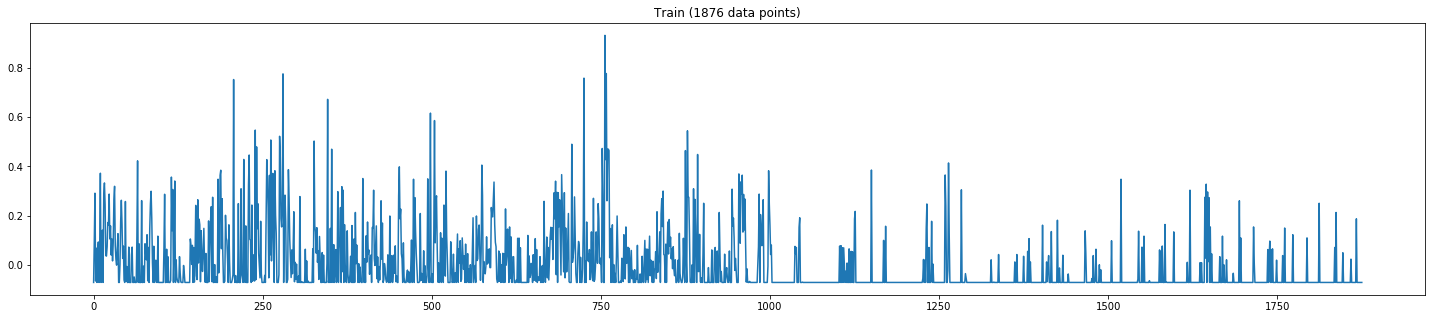

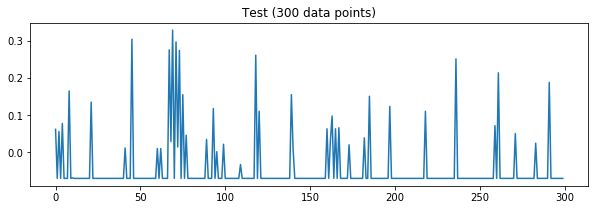

In [15]:
plt.figure(figsize=(25,5))
plt.plot(xTrain[:,0])
plt.title('Train (' +str(len(xTrain))+' data points)')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(xTest[:,0])
plt.title('Test (' +str(len(xTest))+' data points)')
plt.show()

## Placeholders

In [16]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

## Weights and biases
Because is a 3 layer net:
1. Input
2. Hidden Recurrent layer
3. Output

We need 2 pairs of W and b

In [17]:
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

Unpack

In [18]:
labels_series = tf.unstack(batchY_placeholder, axis=1)

## Forward pass - Unroll the cell

Input to recurrent

In [19]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size)

states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)

In [20]:
states_series = tf.transpose(states_series,[1,0,2])

## Backward pass - Output

In [21]:
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

## Weights and bias out

In [22]:
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))

## Prediction, Loss & Optimizer

In [23]:
prediction = tf.matmul(last_state,weight) + bias
prediction

<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>

In [24]:
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))

train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

C:\Users\Jason\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [25]:
loss_list = []
test_pred_list = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            
            batchX = xTrain[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
            batchY = yTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
                
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
           
            
            if(batch_idx % 200 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(xTest) - truncated_backprop_length):
        
        testBatchX = xTest[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
        testBatchY = yTest[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))

        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list.append(test_pred[-1][0]) #The last one

Epoch 0
Step 0 - Loss: 0.074045
Step 200 - Loss: 0.035383
Step 400 - Loss: 0.016286
Step 600 - Loss: 0.010198
Step 800 - Loss: 0.025460
Step 1000 - Loss: 0.001263
Step 1200 - Loss: 0.004831
Step 1400 - Loss: 0.000054
Step 1600 - Loss: 0.004201
Step 1800 - Loss: 0.113654
Epoch 1
Step 0 - Loss: 0.015495
Step 200 - Loss: 0.024148
Step 400 - Loss: 0.013117
Step 600 - Loss: 0.010260
Step 800 - Loss: 0.024163
Step 1000 - Loss: 0.001234
Step 1200 - Loss: 0.005541
Step 1400 - Loss: 0.000084
Step 1600 - Loss: 0.005522
Step 1800 - Loss: 0.110161
Epoch 2
Step 0 - Loss: 0.016117
Step 200 - Loss: 0.022973
Step 400 - Loss: 0.012757
Step 600 - Loss: 0.010530
Step 800 - Loss: 0.023854
Step 1000 - Loss: 0.001221
Step 1200 - Loss: 0.005747
Step 1400 - Loss: 0.000155
Step 1600 - Loss: 0.005756
Step 1800 - Loss: 0.108901
Epoch 3
Step 0 - Loss: 0.016525
Step 200 - Loss: 0.022383
Step 400 - Loss: 0.012730
Step 600 - Loss: 0.010774
Step 800 - Loss: 0.023730
Step 1000 - Loss: 0.001228
Step 1200 - Loss: 0.0058

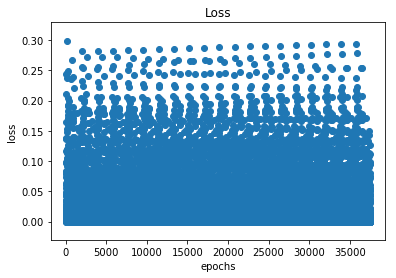

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Loss')
plt.scatter(x=np.arange(0,len(loss_list)),y=loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show();

#### Denormalize

In [27]:
Price = pd.DataFrame(xTest)
Price.head(10)

,0,1,2,3,4,5,6,7
0,0.062068,0.003857,0.134918,0.060510,0.010404,0.065072,0.075407,0.075407
1,-0.069548,-0.001419,-0.482540,-0.032478,-0.037399,-0.120898,0.032747,0.032747
2,0.056346,-0.015912,-0.512174,-0.394146,0.006946,-0.418810,0.096110,0.096110
3,-0.069548,-0.015398,-0.437322,-0.204546,-0.012566,-0.238912,-0.136638,-0.136638
4,0.077805,-0.011902,0.105691,-0.143598,-0.029662,-0.192333,-0.041280,-0.041280
5,-0.069548,0.036076,0.290073,0.211353,0.049853,0.226364,0.069134,0.069134
6,-0.069548,0.048046,0.322099,0.216907,0.024852,0.234724,0.121831,0.121831
7,-0.069548,-0.032293,-0.529213,-0.315139,-0.045384,-0.535217,0.046549,0.046549
8,0.165073,0.007181,-0.211375,0.054502,0.051510,0.285836,0.049686,0.049686
9,-0.069548,0.038373,-0.138346,0.298015,-0.004053,0.280254,0.095483,0.095483


In [28]:
test_pred_list[:] = [(x*price_changeRange)+price_changeMean for x in test_pred_list]
xTest[:] = [(x*price_changeRange)+price_changeMean for x in xTest]
yTest[:] = [(y*price_changeRange)+price_changeMean for y in yTest]

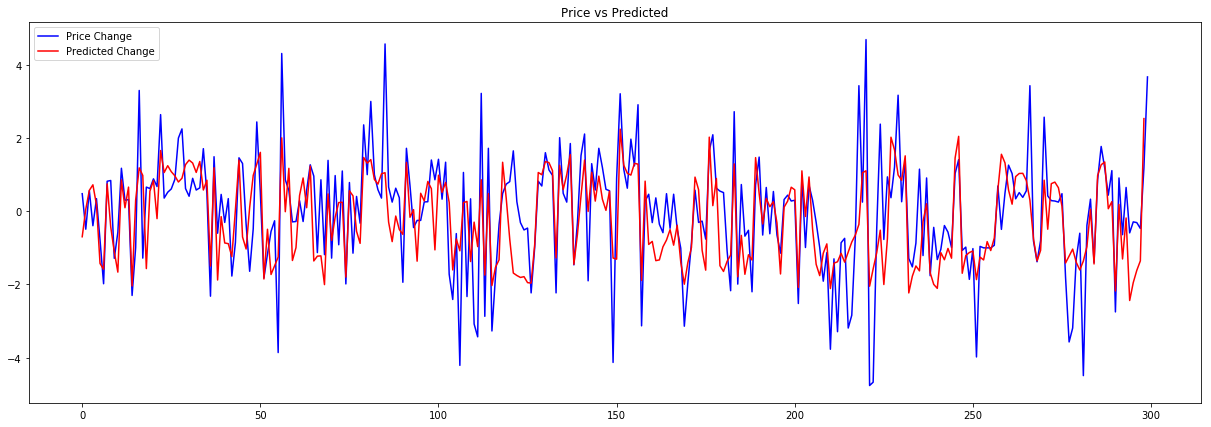

In [29]:
from scipy.ndimage.interpolation import shift
predicted=shift(test_pred_list, -5, cval=0)
plt.figure(figsize=(21,7))
plt.plot(yTest,label='Price Change',color='blue')
#plt.plot(xTest[:,0],label='Baseline')
plt.plot(test_pred_list,label='Predicted Change',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()

In [30]:
len(test_pred_list)

299

In [31]:
pd.DataFrame(test_pred_list, columns=['Prediction']).tail()

,Prediction
294,-2.437875
295,-1.950757
296,-1.614449
297,-1.354423
298,2.531032


In [32]:
predict= pd.DataFrame(test_pred_list, columns=['Prediction'])
Target = pd.DataFrame(yTest, columns=['Target'])
Price = pd.DataFrame(xTest[:,0], columns=['Price'])
realVSpredict = predict.join(Target)
realVSpredict = realVSpredict.join(Price)
with pd.option_context('display.max_rows', None, 'display.max_columns', 4):
    print(realVSpredict)

     Prediction  Target     Price
0     -0.696699   0.480  0.583281
1      0.055474  -0.490 -0.732885
2      0.571153   0.560  0.526056
3      0.722462  -0.395 -0.732885
4      0.178198   0.345  0.740648
5     -1.427425  -0.785 -0.732885
6     -1.584060  -1.980 -0.732885
7      0.747101   0.820 -0.732885
8     -0.424788   0.840  1.613324
9     -1.104487  -1.285 -0.732885
10    -1.662574  -0.575 -0.718579
11     0.855789   1.175 -0.732885
12     0.095686   0.300 -0.732885
13     0.659584   0.320 -0.732885
14    -2.041120  -2.300 -0.732885
15     0.306845  -0.990 -0.732885
16     1.185251   3.300 -0.732885
17     0.978166  -1.280 -0.732885
18    -1.566032   0.660 -0.732885
19     0.548105   0.620 -0.732885
20     0.840557   0.885 -0.732885
21    -0.201801   0.675  1.312894
22     1.659063   2.640 -0.732885
23     1.058087   0.360 -0.732885
24     1.244973   0.520 -0.732885
25     1.081035   0.610 -0.732885
26     0.969000   0.870 -0.732885
27     0.799293   2.000 -0.732885
28     0.90243

In [33]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(realVSpredict['Prediction'],realVSpredict['Target'])
print("r-squared:", r_value**2)

r-squared: 0.448301273143


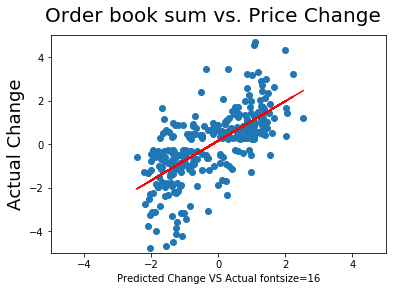

In [34]:

plt.scatter (realVSpredict['Prediction'],realVSpredict['Target'])
plt.suptitle('Order book sum vs. Price Change', fontsize=20)
plt.plot(realVSpredict['Prediction'], intercept + slope*(realVSpredict['Prediction']), 'r', label='fitted line')
plt.ylabel('Actual Change', fontsize=18)
plt.ylim( (-5, 5) )
plt.xlim(-5, 5)
plt.xlabel('Predicted Change VS Actual fontsize=16')
plt.show()

In [35]:
PriceChange = pd.DataFrame(xTest[:,0])
PriceChange.head(10)

,0
0,0.583281
1,-0.732885
2,0.526056
3,-0.732885
4,0.740648
5,-0.732885
6,-0.732885
7,-0.732885
8,1.613324
9,-0.732885


In [36]:
tdt[-3:]

,order_date_time,id
1873,2017-10-05 05:55:23,321899.400000
1874,2017-10-05 06:05:34,323726.166667
1875,2017-10-05 06:06:33,324015.833333


In [37]:
length=len(PriceChange.index)
length

300

In [38]:

#pd.to_datetime(tdt,format='%Y%m%d %H:%M:%S.%f')

In [39]:
dataset_px=dataset_px[-length:]
#backtrader_data= tdt[-length:]

tdt=dataset_px['order_date_time']
Open=dataset_px['trade_px']
High= dataset_px['trade_px']
Low= dataset_px['trade_px']
Close= dataset_px['trade_px']
#Rnn10= ds.join(Price)

backtrader_data = pd.concat([tdt,Open, High, Low, Close], axis=1)
#date_time=pd.to_datetime(backtrader_data.trades_date_time, format="%Y%m%d %H:%M:%S.%f").to_frame()
#backtrader_data = backtrader_data.drop(backtrader_data.index[range(0,5)])
backtrader_data.tail(20)


,order_date_time,trade_px,trade_px,trade_px,trade_px
1856,2017-10-05 05:19:30,4156.605,4156.605,4156.605,4156.605
1857,2017-10-05 05:19:36,4156.005,4156.005,4156.005,4156.005
1858,2017-10-05 05:20:05,4151.515,4151.515,4151.515,4151.515
1859,2017-10-05 05:20:34,4151.135,4151.135,4151.135,4151.135
1860,2017-10-05 05:23:12,4151.465,4151.465,4151.465,4151.465
1861,2017-10-05 05:29:35,4150.135,4150.135,4150.135,4150.135
1862,2017-10-05 05:29:55,4150.995,4150.995,4150.995,4150.995
1863,2017-10-05 05:30:04,4152.765,4152.765,4152.765,4152.765
1864,2017-10-05 05:30:56,4159.205,4159.205,4159.205,4159.205
1865,2017-10-05 05:31:01,4159.645,4159.645,4159.645,4159.645


In [40]:
backtrader_data = backtrader_data.reset_index(drop=True)
backtrader_data=backtrader_data.join(predict)

In [41]:

backtrader_data = backtrader_data.set_index(pd.DatetimeIndex(backtrader_data['order_date_time']))
backtrader_data.drop('order_date_time', axis=1)


,trade_px,trade_px,trade_px,trade_px,Prediction
order_date_time,,,,,
2017-10-04 20:38:36,4199.465,4199.465,4199.465,4199.465,-0.696699
2017-10-04 20:38:41,4199.945,4199.945,4199.945,4199.945,0.055474
2017-10-04 20:38:49,4199.455,4199.455,4199.455,4199.455,0.571153
2017-10-04 20:39:01,4200.015,4200.015,4200.015,4200.015,0.722462
2017-10-04 20:39:49,4199.520,4199.520,4199.520,4199.520,0.178198
2017-10-04 20:40:19,4199.855,4199.855,4199.855,4199.855,-1.427425
2017-10-04 20:42:33,4199.005,4199.005,4199.005,4199.005,-1.584060
2017-10-04 20:43:06,4197.025,4197.025,4197.025,4197.025,0.747101
2017-10-04 20:43:31,4197.845,4197.845,4197.845,4197.845,-0.424788


# For resampling.  Needs work.

In [42]:


#backtrader_data = backtrader_data.resample('s').mean()

#backtrader_data[['Prediction']]=backtrader_data[['Prediction']].fillna(value=0)
#backtrader_data=backtrader_data.fillna(method='bfill')
#backtrader_data.head(30)

In [43]:
backtrader_data.to_csv('BTCUSD_RNN10.csv',index=False)

In [44]:
backtrader_data.index

DatetimeIndex(['2017-10-04 20:38:36', '2017-10-04 20:38:41',
               '2017-10-04 20:38:49', '2017-10-04 20:39:01',
               '2017-10-04 20:39:49', '2017-10-04 20:40:19',
               '2017-10-04 20:42:33', '2017-10-04 20:43:06',
               '2017-10-04 20:43:31', '2017-10-04 20:45:22',
               ...
               '2017-10-05 05:35:43', '2017-10-05 05:36:34',
               '2017-10-05 05:42:34', '2017-10-05 05:43:32',
               '2017-10-05 05:53:50', '2017-10-05 05:55:01',
               '2017-10-05 05:55:14', '2017-10-05 05:55:23',
               '2017-10-05 06:05:34', '2017-10-05 06:06:33'],
              dtype='datetime64[ns]', name='order_date_time', length=300, freq=None)

## 